# Import Necessary Modules

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

# Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain.

In [17]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

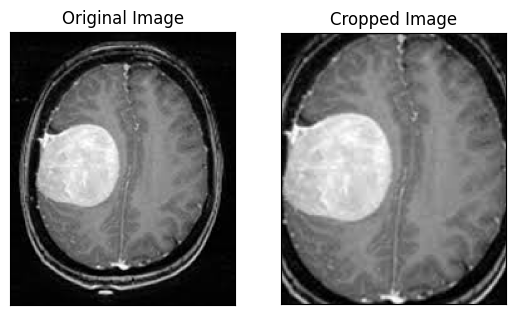

In [18]:
ex_img = cv2.imread('./brain_tumor_dataset/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

# Load up the data:
The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:

1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to X and its label to y.
After that, Shuffle X and y, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).
Finally, Return X and y.

In [19]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [20]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


# Plot Sample Images

In [21]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

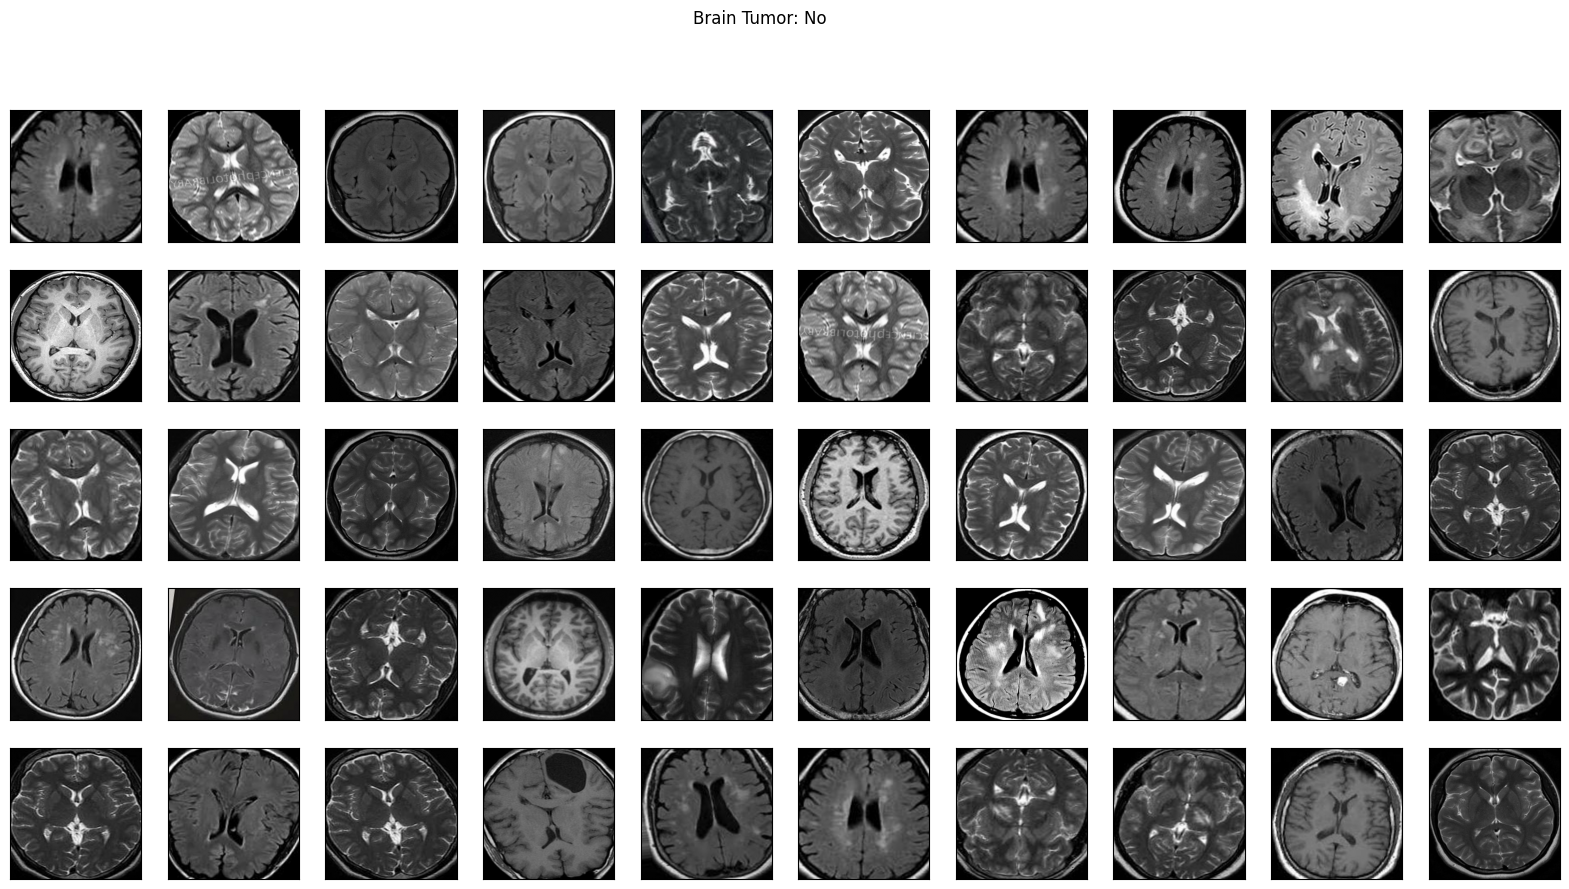

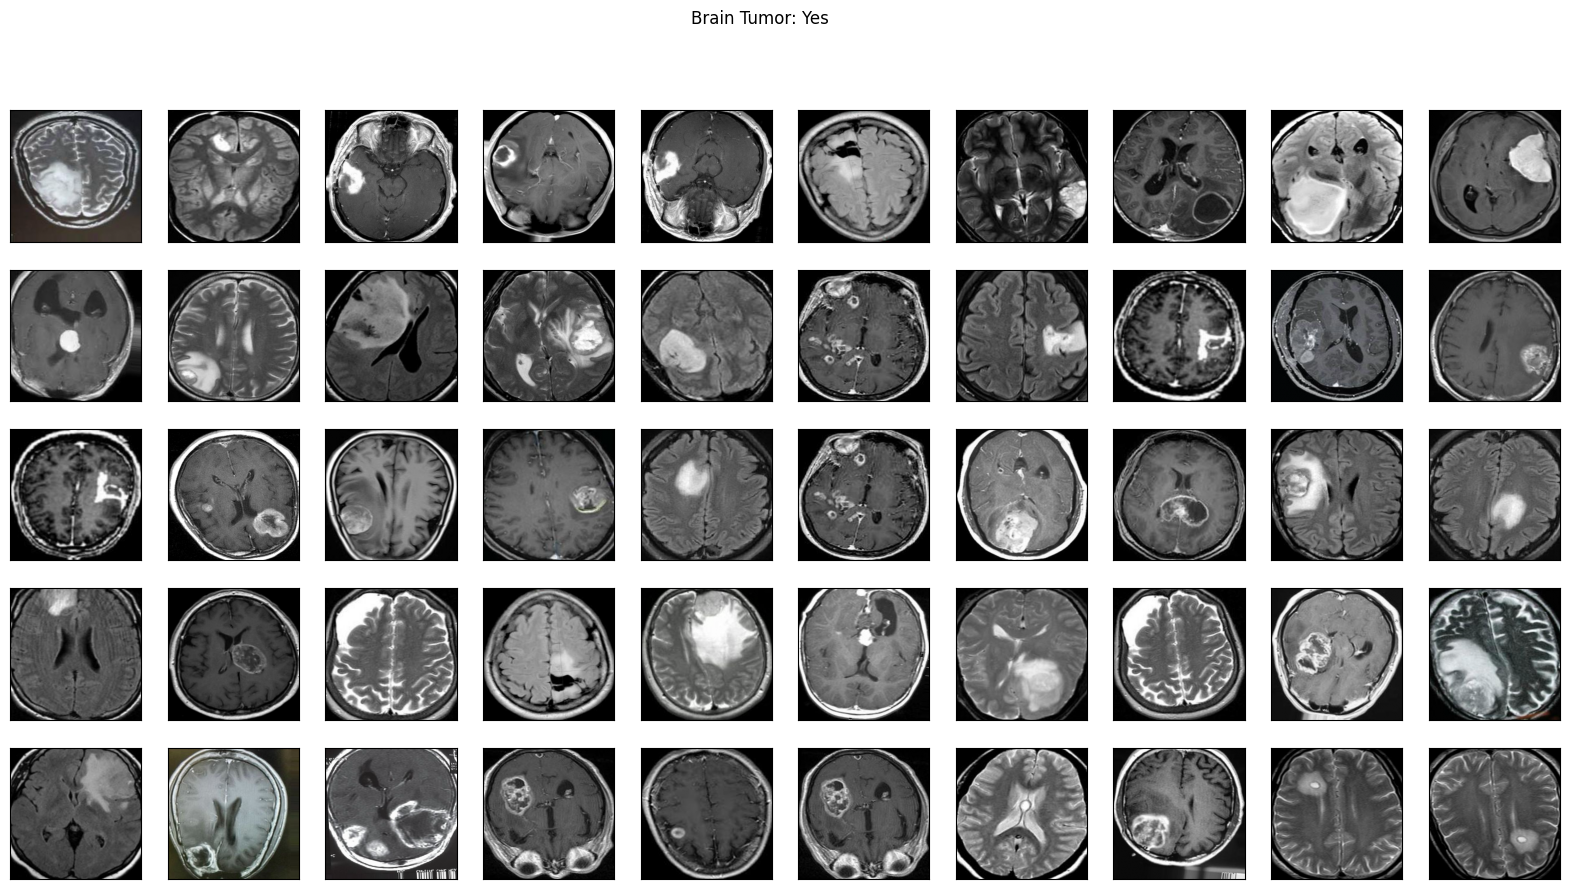

In [22]:
plot_sample_images(X, y)

## Split the Data:
Split X and y into training, validation (development) and validation sets.

In [23]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:

1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [24]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [25]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [26]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [27]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

## Build the model
Let's build a convolutional neural network model:

In [28]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [29]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [30]:
model = build_model(IMG_SHAPE)

In [31]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 244, 244, 3)       0         
 ing2D)                                                          
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [34]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [35]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.8483 - accuracy: 0.6042INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.61.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.61.model\assets


46/46 [==============================] - 47s 978ms/step - loss: 0.8483 - accuracy: 0.6042 - val_loss: 0.6563 - val_accuracy: 0.6097
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.4793 - accuracy: 0.7751INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.75.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.75.model\assets


46/46 [==============================] - 50s 1s/step - loss: 0.4793 - accuracy: 0.7751 - val_loss: 0.6117 - val_accuracy: 0.7516
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 0.4351 - accuracy: 0.8014INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.73.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.73.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.4351 - accuracy: 0.8014 - val_loss: 0.5691 - val_accuracy: 0.7290
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.8215INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.79.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.79.model\assets


46/46 [==============================] - 61s 1s/step - loss: 0.3945 - accuracy: 0.8215 - val_loss: 0.5132 - val_accuracy: 0.7935
Epoch 5/10
46/46 [==============================] - ETA: 0s - loss: 0.3791 - accuracy: 0.8325INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.64.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.64.model\assets


46/46 [==============================] - 62s 1s/step - loss: 0.3791 - accuracy: 0.8325 - val_loss: 0.5942 - val_accuracy: 0.6419
Epoch 6/10
46/46 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.8775INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.78.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.78.model\assets


46/46 [==============================] - 63s 1s/step - loss: 0.2952 - accuracy: 0.8775 - val_loss: 0.4311 - val_accuracy: 0.7839
Epoch 7/10
46/46 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.8817INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.74.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.74.model\assets


46/46 [==============================] - 61s 1s/step - loss: 0.2910 - accuracy: 0.8817 - val_loss: 0.4787 - val_accuracy: 0.7355
Epoch 8/10
46/46 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.8824INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.81.model\assets


46/46 [==============================] - 63s 1s/step - loss: 0.2898 - accuracy: 0.8824 - val_loss: 0.3648 - val_accuracy: 0.8065
Epoch 9/10
46/46 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.8761INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.87.model\assets


46/46 [==============================] - 63s 1s/step - loss: 0.2758 - accuracy: 0.8761 - val_loss: 0.3204 - val_accuracy: 0.8710
Epoch 10/10
46/46 [==============================] - ETA: 0s - loss: 0.1947 - accuracy: 0.9308INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.74.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.74.model\assets


46/46 [==============================] - 63s 1s/step - loss: 0.1947 - accuracy: 0.9308 - val_loss: 0.4839 - val_accuracy: 0.7387
Elapsed time: 0:9:52.0


In [36]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9114INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.86.model\assets


46/46 [==============================] - 63s 1s/step - loss: 0.2189 - accuracy: 0.9114 - val_loss: 0.3028 - val_accuracy: 0.8645
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9301INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.80.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.80.model\assets


46/46 [==============================] - 64s 1s/step - loss: 0.1881 - accuracy: 0.9301 - val_loss: 0.3915 - val_accuracy: 0.8000
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.9315INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets


46/46 [==============================] - 65s 1s/step - loss: 0.1748 - accuracy: 0.9315 - val_loss: 0.2651 - val_accuracy: 0.8871
Elapsed time: 0:3:13.3


In [37]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9571INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.76.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.76.model\assets


46/46 [==============================] - 64s 1s/step - loss: 0.1381 - accuracy: 0.9571 - val_loss: 0.5456 - val_accuracy: 0.7613
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9633INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.75.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.75.model\assets


46/46 [==============================] - 60s 1s/step - loss: 0.1376 - accuracy: 0.9633 - val_loss: 0.5769 - val_accuracy: 0.7484
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9647INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.82.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.82.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.1240 - accuracy: 0.9647 - val_loss: 0.4702 - val_accuracy: 0.8161
Elapsed time: 0:3:2.5


In [38]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9626INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.57.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.57.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.1263 - accuracy: 0.9626 - val_loss: 1.2772 - val_accuracy: 0.5710
Epoch 2/50
46/46 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9384INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.87.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.1559 - accuracy: 0.9384 - val_loss: 0.2581 - val_accuracy: 0.8742
Epoch 3/50
46/46 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9633INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.87.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.1159 - accuracy: 0.9633 - val_loss: 0.2663 - val_accuracy: 0.8742
Epoch 4/50
46/46 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9772INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.88.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.0867 - accuracy: 0.9772 - val_loss: 0.2469 - val_accuracy: 0.8839
Epoch 5/50
46/46 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9765INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.87.model\assets


46/46 [==============================] - 59s 1s/step - loss: 0.0923 - accuracy: 0.9765 - val_loss: 0.2630 - val_accuracy: 0.8677
Epoch 6/50
46/46 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9730INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.88.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.0967 - accuracy: 0.9730 - val_loss: 0.2453 - val_accuracy: 0.8839
Epoch 7/50
46/46 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9820INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.87.model\assets


46/46 [==============================] - 54s 1s/step - loss: 0.0785 - accuracy: 0.9820 - val_loss: 0.2764 - val_accuracy: 0.8677
Epoch 8/50
46/46 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9730INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.90.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.0854 - accuracy: 0.9730 - val_loss: 0.2215 - val_accuracy: 0.8968
Epoch 9/50
46/46 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9869INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.88.model\assets


46/46 [==============================] - 59s 1s/step - loss: 0.0623 - accuracy: 0.9869 - val_loss: 0.3148 - val_accuracy: 0.8839
Epoch 10/50
46/46 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9917INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.89.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.0568 - accuracy: 0.9917 - val_loss: 0.2937 - val_accuracy: 0.8935
Epoch 11/50
46/46 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9855INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.90.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.0646 - accuracy: 0.9855 - val_loss: 0.2453 - val_accuracy: 0.8968
Epoch 12/50
46/46 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9958INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.89.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.0483 - accuracy: 0.9958 - val_loss: 0.2463 - val_accuracy: 0.8871
Epoch 13/50
46/46 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9972INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-13-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-13-0.89.model\assets


46/46 [==============================] - 56s 1s/step - loss: 0.0423 - accuracy: 0.9972 - val_loss: 0.2605 - val_accuracy: 0.8903
Epoch 14/50
46/46 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9972INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-14-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-14-0.89.model\assets


46/46 [==============================] - 54s 1s/step - loss: 0.0383 - accuracy: 0.9972 - val_loss: 0.2465 - val_accuracy: 0.8935
Epoch 15/50
46/46 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9972INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.89.model\assets


46/46 [==============================] - 55s 1s/step - loss: 0.0391 - accuracy: 0.9972 - val_loss: 0.2404 - val_accuracy: 0.8903
Epoch 16/50
46/46 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9938INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-16-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-16-0.89.model\assets


46/46 [==============================] - 56s 1s/step - loss: 0.0468 - accuracy: 0.9938 - val_loss: 0.2614 - val_accuracy: 0.8903
Epoch 17/50
46/46 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9945INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-17-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-17-0.84.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.0433 - accuracy: 0.9945 - val_loss: 0.3847 - val_accuracy: 0.8387
Epoch 18/50
46/46 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9972INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-18-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-18-0.90.model\assets


46/46 [==============================] - 55s 1s/step - loss: 0.0353 - accuracy: 0.9972 - val_loss: 0.2048 - val_accuracy: 0.9032
Epoch 19/50
46/46 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9986INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-19-0.92.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-19-0.92.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.0299 - accuracy: 0.9986 - val_loss: 0.2011 - val_accuracy: 0.9194
Epoch 20/50
46/46 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9972INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-20-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-20-0.88.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.0330 - accuracy: 0.9972 - val_loss: 0.2971 - val_accuracy: 0.8806
Epoch 21/50
46/46 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-21-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-21-0.87.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.0282 - accuracy: 0.9993 - val_loss: 0.3298 - val_accuracy: 0.8710
Epoch 22/50
46/46 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9986INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-22-0.92.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-22-0.92.model\assets


46/46 [==============================] - 61s 1s/step - loss: 0.0261 - accuracy: 0.9986 - val_loss: 0.2074 - val_accuracy: 0.9161
Epoch 23/50
46/46 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-23-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-23-0.91.model\assets


46/46 [==============================] - 60s 1s/step - loss: 0.0229 - accuracy: 0.9993 - val_loss: 0.2151 - val_accuracy: 0.9065
Epoch 24/50
46/46 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-24-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-24-0.90.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.0206 - accuracy: 0.9993 - val_loss: 0.2330 - val_accuracy: 0.9032
Epoch 25/50
46/46 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9979INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-25-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-25-0.84.model\assets


46/46 [==============================] - 61s 1s/step - loss: 0.0275 - accuracy: 0.9979 - val_loss: 0.3878 - val_accuracy: 0.8387
Epoch 26/50
46/46 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-26-0.85.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-26-0.85.model\assets


46/46 [==============================] - 59s 1s/step - loss: 0.0196 - accuracy: 0.9993 - val_loss: 0.3565 - val_accuracy: 0.8452
Epoch 27/50
46/46 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-27-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-27-0.90.model\assets


46/46 [==============================] - 59s 1s/step - loss: 0.0175 - accuracy: 0.9993 - val_loss: 0.2189 - val_accuracy: 0.9032
Epoch 28/50
46/46 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-28-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-28-0.87.model\assets


46/46 [==============================] - 60s 1s/step - loss: 0.0161 - accuracy: 0.9993 - val_loss: 0.3227 - val_accuracy: 0.8710
Epoch 29/50
46/46 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-29-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-29-0.91.model\assets


46/46 [==============================] - 59s 1s/step - loss: 0.0155 - accuracy: 0.9993 - val_loss: 0.1955 - val_accuracy: 0.9129
Epoch 30/50
46/46 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-30-0.76.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-30-0.76.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.0162 - accuracy: 0.9993 - val_loss: 0.7570 - val_accuracy: 0.7645
Epoch 31/50
46/46 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9979INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-31-0.85.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-31-0.85.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.0205 - accuracy: 0.9979 - val_loss: 0.4342 - val_accuracy: 0.8516
Epoch 32/50
46/46 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 1.0000INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-32-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-32-0.90.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.2423 - val_accuracy: 0.8968
Epoch 33/50
46/46 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9965INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-33-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-33-0.88.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.0333 - accuracy: 0.9965 - val_loss: 0.3140 - val_accuracy: 0.8806
Epoch 34/50
46/46 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-34-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-34-0.89.model\assets


46/46 [==============================] - 56s 1s/step - loss: 0.0163 - accuracy: 0.9993 - val_loss: 0.2178 - val_accuracy: 0.8935
Epoch 35/50
46/46 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-35-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-35-0.87.model\assets


46/46 [==============================] - 55s 1s/step - loss: 0.0178 - accuracy: 0.9993 - val_loss: 0.3553 - val_accuracy: 0.8710
Epoch 36/50
46/46 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-36-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-36-0.91.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.0156 - accuracy: 0.9993 - val_loss: 0.2131 - val_accuracy: 0.9097
Epoch 37/50
46/46 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 1.0000INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-37-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-37-0.91.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.2135 - val_accuracy: 0.9097
Epoch 38/50
46/46 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 1.0000INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-38-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-38-0.91.model\assets


46/46 [==============================] - 58s 1s/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1957 - val_accuracy: 0.9129
Epoch 39/50
46/46 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-39-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-39-0.91.model\assets


46/46 [==============================] - 57s 1s/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.2007 - val_accuracy: 0.9129
Epoch 40/50
46/46 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-40-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-40-0.84.model\assets


46/46 [==============================] - 56s 1s/step - loss: 0.0219 - accuracy: 0.9993 - val_loss: 0.5232 - val_accuracy: 0.8419
Epoch 41/50
46/46 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-41-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-41-0.91.model\assets


46/46 [==============================] - 55s 1s/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.2252 - val_accuracy: 0.9065
Epoch 42/50
46/46 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 1.0000INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-42-0.92.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-42-0.92.model\assets


46/46 [==============================] - 56s 1s/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.2134 - val_accuracy: 0.9161
Epoch 43/50
46/46 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-43-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-43-0.91.model\assets


46/46 [==============================] - 56s 1s/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.2073 - val_accuracy: 0.9097
Epoch 44/50
46/46 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9993INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-44-0.92.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-44-0.92.model\assets


46/46 [==============================] - 55s 1s/step - loss: 0.0160 - accuracy: 0.9993 - val_loss: 0.2547 - val_accuracy: 0.9226
Epoch 45/50
46/46 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 1.0000INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-45-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-45-0.91.model\assets


46/46 [==============================] - 55s 1s/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.2395 - val_accuracy: 0.9097
Epoch 46/50
46/46 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9965INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-46-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-46-0.88.model\assets


46/46 [==============================] - 55s 1s/step - loss: 0.0165 - accuracy: 0.9965 - val_loss: 0.3809 - val_accuracy: 0.8806
Epoch 47/50
46/46 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9225INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-47-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-47-0.86.model\assets


46/46 [==============================] - 55s 1s/step - loss: 0.2222 - accuracy: 0.9225 - val_loss: 0.4015 - val_accuracy: 0.8613
Epoch 48/50
46/46 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9779INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-48-0.85.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-48-0.85.model\assets


46/46 [==============================] - 55s 1s/step - loss: 0.0659 - accuracy: 0.9779 - val_loss: 0.4467 - val_accuracy: 0.8484
Epoch 49/50
46/46 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9917INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-49-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-49-0.90.model\assets


46/46 [==============================] - 56s 1s/step - loss: 0.0372 - accuracy: 0.9917 - val_loss: 0.2838 - val_accuracy: 0.8968
Epoch 50/50
46/46 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9952INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-50-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-50-0.86.model\assets


46/46 [==============================] - 61s 1s/step - loss: 0.0322 - accuracy: 0.9952 - val_loss: 0.3394 - val_accuracy: 0.8645
Elapsed time: 0:47:40.0


In [39]:
history = model.history.history

In [40]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


Plot Loss & Accuracy

In [41]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

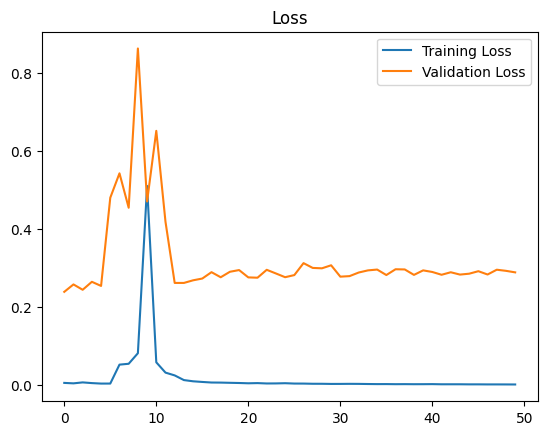

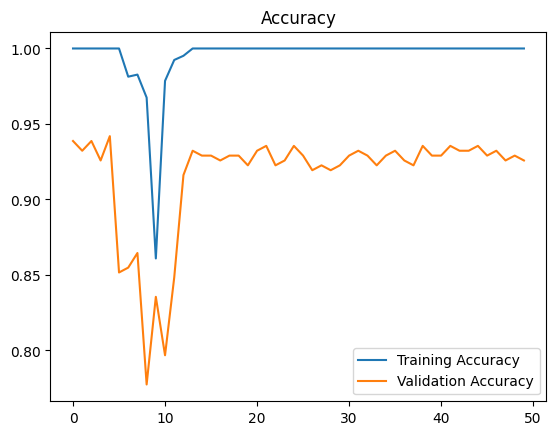

In [ ]:
plot_metrics(history) 

# Results
Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 44th iteration with validation accuracy of 92%

In [42]:
best_model = load_model(filepath='models\cnn-parameters-improvement-44-0.92.model')

In [43]:
best_model.metrics_names

['loss', 'accuracy']

In [44]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 2s 171ms/step - loss: 0.3104 - accuracy: 0.9129


Accuracy of the best model on the testing data:

In [45]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.3103669583797455
Test Accuracy = 0.9129032492637634


F1 score for the best model on the testing data:

In [46]:
y_test_prob = best_model.predict(X_test)

10/10 [==============================] - 2s 173ms/step


In [47]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9208211143695014


Let's also find the f1 score on the validation data:

In [48]:
y_val_prob = best_model.predict(X_val)

10/10 [==============================] - 2s 176ms/step


In [49]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9263803680981595


# Results Interpretation
Let's remember the percentage of positive and negative examples:

In [50]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [51]:
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [52]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 53.01038062283737%, number of pos examples: 766
Percentage of negative examples: 46.98961937716263%, number of neg examples: 679
Validation Data:
Number of examples: 310
Percentage of positive examples: 50.0%, number of pos examples: 155
Percentage of negative examples: 50.0%, number of neg examples: 155
Testing Data:
Number of examples: 310
Percentage of positive examples: 52.903225806451616%, number of pos examples: 164
Percentage of negative examples: 47.096774193548384%, number of neg examples: 146


As expectred, the percentage of positive examples are around 50%.